In [9]:
import torch
##model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

In [10]:
import torch
import esm

model_name: esm2_t36_3B_UR50D.pt
.
esm2_t36_3B_UR50D.pt
.
esm2_t36_3B_UR50D
0
token_representations: torch.Size([4, 73, 2560])
batc_lens: tensor([104,  65,  65,   8])
i: 0
tokens_len: tensor(104)
i: 1
tokens_len: tensor(65)
i: 2
tokens_len: tensor(65)
i: 3
tokens_len: tensor(8)
sequence_representations: torch.Size([2560])


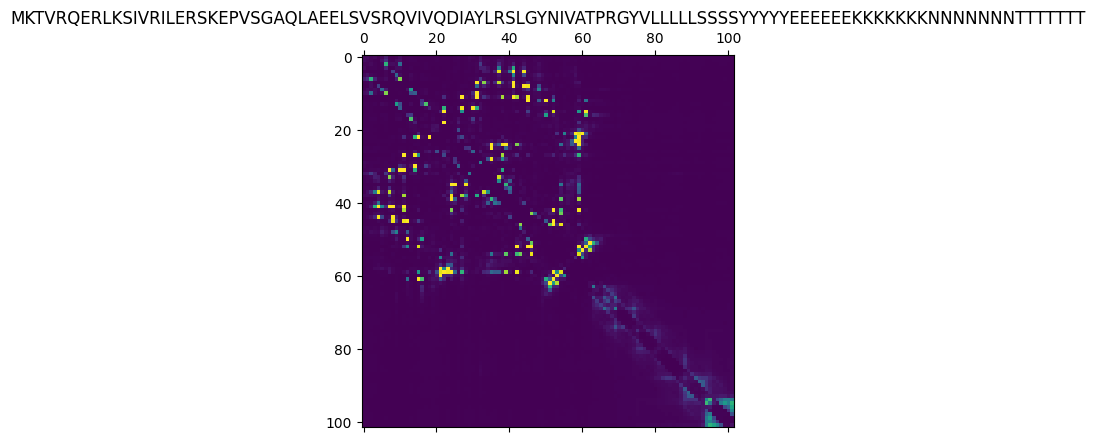

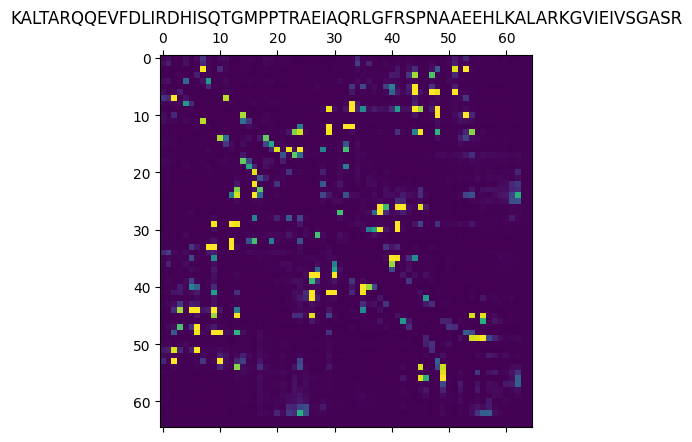

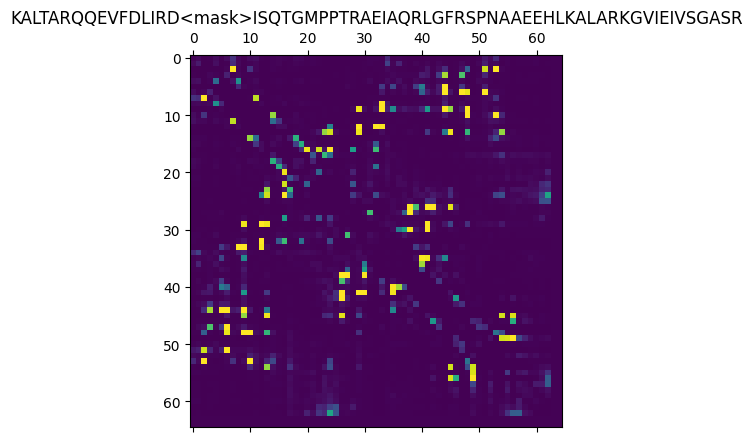

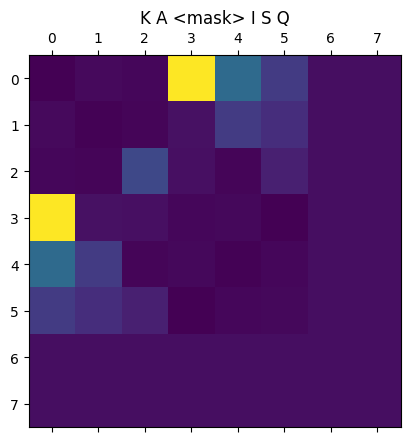

In [17]:
model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results
print(alphabet.cls_idx)
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLLLLLSSSSYYYYYEEEEEEKKKKKKKNNNNNNNTTTTTTT"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASR"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASR"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    
#print('representations:',results["representations"])
#token_representations = results["representations"][31]
print('token_representations:',token_representations.shape)
#token_representations32 = results["representations"][32]
#print('token_representations:',token_representations.shape)
#print('token_representations:',results["representations"].shape)
#print('token_representations:',results["representations"][32].shape)
#print('token_representations:',results["representations"][31].shape)
#print('token_representations:',results["representations"][30].shape)

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
print('batc_lens:',batch_lens)
for i, tokens_len in enumerate(batch_lens):
    print('i:',i)
    print('tokens_len:',tokens_len)
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
print('sequence_representations:',sequence_representations[1].shape)
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [ ]:
#ESMFold Structure Pediction

In [4]:
import torch
import esm

model = esm.pretrained.esmfold_v1()
model = model.eval().cuda()

# Optionally, uncomment to set a chunk size for axial attention. This can help reduce memory.
# Lower sizes will have lower memory requirements at the cost of increased speed.
# model.set_chunk_size(128)

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"
# Multimer prediction can be done with chains separated by ':'

with torch.no_grad():
    output = model.infer_pdb(sequence)

with open("result.pdb", "w") as f:
    f.write(output)

import biotite.structure.io as bsio
struct = bsio.load_structure("result.pdb", extra_fields=["b_factor"])
print(struct.b_factor.mean())  # this will be the pLDDT

.
.
esm2_t36_3B_UR50D.pt
.
esm2_t36_3B_UR50D
88.28883399209487
